<a href="https://colab.research.google.com/github/rhiosutoyo/Teaching-Deep-Learning-and-Its-Applications/blob/main/9_1_generative_networks_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

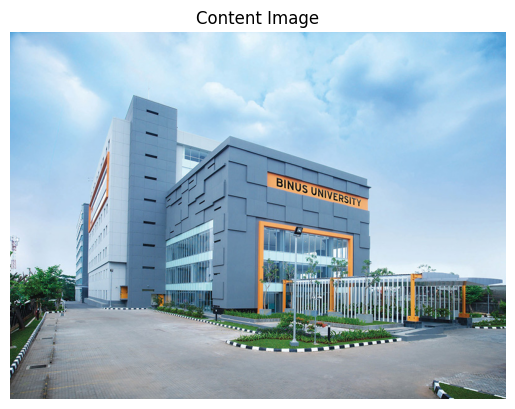

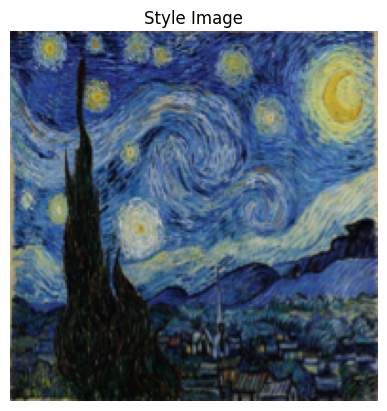

In [2]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Correct URLs for the content and style images
content_url = 'https://raw.githubusercontent.com/rhiosutoyo/Teaching-Deep-Learning-and-Its-Applications/main/images/9-1-content-image-binus.jpg'
style_url = 'https://raw.githubusercontent.com/rhiosutoyo/Teaching-Deep-Learning-and-Its-Applications/main/images/9-1-style-image.png'

# Function to fetch and display image
def fetch_and_display_image(url, title):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the images
fetch_and_display_image(content_url, 'Content Image')
print() # add line spacing
fetch_and_display_image(style_url, 'Style Image')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Function to load and preprocess the image
def load_image(img_url, transform=None, max_size=400, shape=None):
    response = requests.get(img_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    if max_size:
        scale = max_size / max(image.size)
        size = int(scale * image.size[0]), int(scale * image.size[1])
        image = image.resize(size, Image.ANTIALIAS)

    if shape:
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)

    return image

# Define the image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the content and style images
content = load_image(content_url, transform)
style = load_image(style_url, transform, shape=[content.size(2), content.size(3)])

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

content = content.to(device)
style = style.to(device)

# Load the VGG19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Define the layers to use for content and style loss
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Define a function to extract features
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Define a function to calculate the gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Extract features from content and style images
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the gram matrices for each layer of the style image
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a target image and make it require gradients
target = content.clone().requires_grad_(True).to(device)

# Set weights for each style layer and content weight
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1  # alpha
style_weight = 1e6  # beta

# Set optimizer
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # Decide how many iterations to update your image (5000 recommended)

# Define the loss functions
content_loss = torch.nn.MSELoss()
style_loss = torch.nn.MSELoss()

# Style Transfer
for step in range(steps):
    # Get the features from the target image
    target_features = get_features(target, vgg)

    # Calculate the content loss
    content_loss_value = content_loss(target_features['conv4_2'], content_features['conv4_2'])

    # Calculate the style loss
    style_loss_value = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * style_loss(target_gram, style_gram)
        _, d, h, w = target_feature.shape
        style_loss_value += layer_style_loss / (d * h * w)

    # Calculate the total loss
    total_loss = content_weight * content_loss_value + style_weight * style_loss_value

    # Update target image
    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)
    optimizer.step()

    # Print the loss every 50 steps
    if step % 50 == 0:
        print(f"Step {step}, Total loss: {total_loss.item()}")

# De-normalize the image and convert it to a PIL image
final_img = target.cpu().clone().squeeze()
final_img = final_img * torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1) + torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1)
final_img = final_img.clamp(0, 1)
final_img = transforms.ToPILImage()(final_img)

<ipython-input-3-e4760563e246>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(size, Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0, Total loss: 162511296.0
Step 50, Total loss: 62466756.0
Step 100, Total loss: 42230072.0
Step 150, Total loss: 33631732.0
Step 200, Total loss: 28783894.0
Step 250, Total loss: 25431446.0
Step 300, Total loss: 22830868.0
Step 350, Total loss: 20675918.0
Step 400, Total loss: 18822990.0
Step 450, Total loss: 17200916.0
Step 500, Total loss: 15771189.0
Step 550, Total loss: 14503557.0
Step 600, Total loss: 13372451.0
Step 650, Total loss: 12360633.0
Step 700, Total loss: 11453882.0
Step 750, Total loss: 10640444.0
Step 800, Total loss: 9910954.0
Step 850, Total loss: 9256629.0
Step 900, Total loss: 8669221.0
Step 950, Total loss: 8141457.5
Step 1000, Total loss: 7667809.5
Step 1050, Total loss: 7241458.0
Step 1100, Total loss: 6856488.5
Step 1150, Total loss: 6508023.5
Step 1200, Total loss: 6192443.0
Step 1250, Total loss: 5905788.0
Step 1300, Total loss: 5644359.0
Step 1350, Total loss: 5404915.0
Step 1400, Total loss: 5184945.5
Step 1450, Total loss: 4981752.5
Step 1500, Total

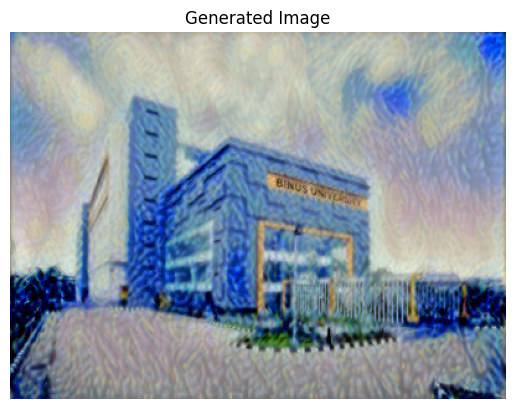

In [4]:
# Display the generated image result from neural style transfer
plt.imshow(final_img)
plt.title('Generated Image')
plt.axis('off')
plt.show()